# Copyright

<PRE>
Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Use this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Author classification
The task is to train a 1D CNN or an LSTM that is able to  classify text from two authors. The final model should be able to tell about a text with a given length (e.g. 60 characters) who wrote it.

Please write the codes according to the following parts:

## Python module imports
Import all Python modules that you would need during the Assignment.

In [122]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import numpy as np


## Data acquisition
Seek a possible dataset, you can use any source, e.g.
* http://www.gutenberg.org/
* https://www.kaggle.com/datasets
* https://paperswithcode.com/datasets
* if you would like to learn Hungarian, than e.g. https://mek.oszk.hu/

You can download the text by hand (e.g. by copy-pasting some parts into txt files) or with Python.

In [97]:
import requests

url = "https://gutenberg.org/cache/epub/73510/pg73510.txt"
response = requests.get(url)

# Save the response content to a file
with open("data1.txt", "wb") as file:
    file.write(response.content)

url = "https://gutenberg.org/cache/epub/73503/pg73503.txt"
response = requests.get(url)

# Save the response content to a file
with open("data2.txt", "wb") as file:
    file.write(response.content)


## Data analysis
Count the number of characters from both authors and display them on a plot (e.g. Seaborn's countplot).

<Axes: xlabel='text', ylabel='word_count'>

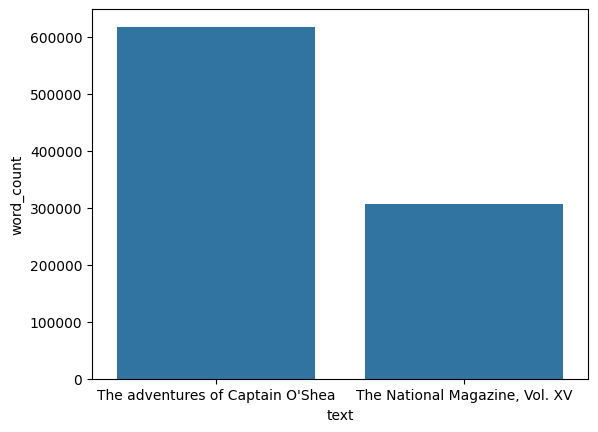

In [98]:
import pandas as pd
import seaborn as sns
content1 = ""
content2 = ""


# Read data1.txt
with open("data1.txt", "r", encoding="utf8") as file:
    content1 = file.read()
    char_count1 = len(content1)

# Read data2.txt
with open("data2.txt", "r", encoding="utf8") as file:
    content2 = file.read()
    char_count2 = len(content2)



# show word_count1 and word_count2 in a bar plot
data = {"word_count": [char_count1, char_count2], "text": ["The adventures of Captain O'Shea", "The National Magazine, Vol. XV"]}
df = pd.DataFrame(data)
sns.barplot(x="text", y="word_count", data=df)



## Data loading, labeling and preprocessing
Load the data and convert the characters into one-hot encodings. Then load the data into a 3D NumPy array, with a shape of

* (batch, sequence_length, alphabet_length)

where sequence_length=60, and alphabet_length equals to the number of unique characters in both datasets. The sequences should be cut out from the complete dataset by sliding window. You should add 0 and 1 labels to the sequences, according to the author.

Later you may change sequence_length to achieve better results!

In [99]:
seq_length = 60
alphabet = "".join(set(content1 + content2))
alphabet = sorted(alphabet)
alphabet_length = len(alphabet)

# char to one hot encoding
char_to_int = {char: i for i, char in enumerate(alphabet)}
int_to_char = {i: char for i, char in enumerate(alphabet)}

# go through the text with a sliding window of size seq_length
# and create sequences of size seq_length 

batch = int((len(content1)+len(content2))/seq_length)


In [100]:
# we store for each sequence which book it belongs to 0 or 1
X = np.zeros((batch, seq_length, alphabet_length))
Y = np.zeros((batch, 1))

In [101]:
#cut off the last part of the text that is not a full sequence
leftover1 = len(content1) % seq_length
content1 = content1[:-leftover1]

leftover2 = len(content2) % seq_length
content2 = content2[:-leftover2]

In [102]:
for i in range(0, len(content1) + len(content2) - seq_length, seq_length):
    if(i + seq_length < len(content1)):
        for j in range(seq_length):
            X[i//seq_length, j, char_to_int[content1[i+j]]] = 1
        Y[i//seq_length] = 0
    else:
        for j in range(seq_length):
            X[i//seq_length, j, char_to_int[content2[i+j-len(content1)]]] = 1
        Y[i//seq_length] = 1

In [103]:
#count the number of 1s and 0s in Y
np.sum(Y), len(Y) - np.sum(Y)

(5104.0, 10303.0)

In [104]:
for i in range(0 ,len(content1), seq_length):
    seq = []
    for char in content1[i: i + seq_length]:
        one_hut = np.zeros((vocab_size))
        one_hut[char_to_int[char]] = 1
        seq.append(one_hut)
    sequences.append(new_data)

In [105]:
for i in range(len(content1), -1 , seq_length):
    seq = []
    for char in content1[i: i + seq_length]:
        one_hut = np.zeros((vocab_size))
        one_hut[char_to_int[char]] = 1
        seq.append(one_hut)
    new_data = {1: seq}
    sequences.append(new_data)

## Data splitting
Split the data into train, validate and test sets. Make

In [106]:
#shouffle X and Y
from sklearn.utils import shuffle
X, Y = shuffle(X, Y)

In [107]:
from sklearn.model_selection import train_test_split

# Splitting the data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

# Splitting the train set into train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Printing the shapes of the resulting sets
print("Train set shape:", X_train.shape, Y_train.shape)
print("Validation set shape:", X_val.shape, Y_val.shape)
print("Test set shape:", X_test.shape, Y_test.shape)


Train set shape: (11092, 60, 104) (11092, 1)
Validation set shape: (2774, 60, 104) (2774, 1)
Test set shape: (1541, 60, 104) (1541, 1)


## Model definition
Define a 1D CNN or an LSTM for the task. Compile the model with the correct loss function.

In [129]:
model = Sequential()

model.add(LSTM(100, input_shape=(seq_length, alphabet_length)))
# model.add(Conv1D(64, 3, input_shape = (seq_length, alphabet_length), activation="relu", kernel_initializer="he_normal"))
model.add(Dense(1, activation="sigmoid"))

#tested both, got better results with LSTM

## Model training
Train the model and apply early stopping.

In [130]:
from keras.callbacks import EarlyStopping

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

In [131]:
# Train the model with early stopping
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10, batch_size=32, callbacks=[early_stopping])

Epoch 1/10
347/347 [==============================] - 13s 32ms/step - loss: 0.6026 - accuracy: 0.6857 - val_loss: 0.4915 - val_accuracy: 0.7570
Epoch 2/10
347/347 [==============================] - 10s 29ms/step - loss: 0.4788 - accuracy: 0.7702 - val_loss: 0.4521 - val_accuracy: 0.7772
Epoch 3/10
347/347 [==============================] - 11s 33ms/step - loss: 0.4507 - accuracy: 0.7839 - val_loss: 0.4573 - val_accuracy: 0.7826
Epoch 4/10
347/347 [==============================] - 11s 31ms/step - loss: 0.4478 - accuracy: 0.7835 - val_loss: 0.4521 - val_accuracy: 0.7747
Epoch 5/10
347/347 [==============================] - 11s 33ms/step - loss: 0.4406 - accuracy: 0.7870 - val_loss: 0.4913 - val_accuracy: 0.7462
Epoch 6/10
347/347 [==============================] - 10s 29ms/step - loss: 0.4335 - accuracy: 0.7954 - val_loss: 0.4364 - val_accuracy: 0.7862
Epoch 7/10
347/347 [==============================] - 10s 29ms/step - loss: 0.4226 - accuracy: 0.7959 - val_loss: 0.4201 - val_accuracy:

## Evaluation on test data
Evaluate the model on the test data in terms of loss and accuracy.

In [132]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
evaluation = model.evaluate(X_test, Y_test)
print("Loss: ", evaluation[0])
print("Accuracy: ", evaluation[1])


49/49 [==============================] - 1s 9ms/step - loss: 0.4167 - accuracy: 0.8014
Loss:  0.41674143075942993
Accuracy:  0.8014276623725891


## Confusion matrix
Calculate and display the confusion matrix.

49/49 [==============================] - 1s 10ms/step


<Axes: >

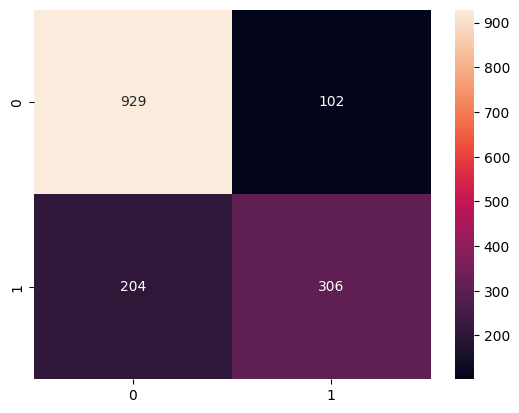

In [133]:
import numpy as np
from sklearn.metrics import confusion_matrix

preds = model.predict(X_test)

# Convert the predictions to binary
preds = np.round(preds)

# Calculate the confusion matrix
cm = confusion_matrix(Y_test, preds)

#plot with seaborn
sns.heatmap(cm, annot=True, fmt="d")